In [137]:
import os

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression  # Fix the typo here
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [139]:
store_sales = pd.read_csv("train.csv")
store_sales.head(10)

,date,region,item,sales
0,01/01/2018,1,1,13
1,01/02/2018,1,1,11
2,01/03/2018,1,1,14
3,01/04/2018,1,1,13
4,01/05/2018,1,1,10
5,01/06/2018,1,1,12
6,01/07/2018,1,1,10
7,01/08/2018,1,1,9
8,01/09/2018,1,1,12
9,01/10/2018,1,1,9


# New Section

In [140]:
#check for null values in dataset
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   region  913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [141]:
#dropping region and item column
store_sales = store_sales.drop(['region', 'item'], axis=1)

In [142]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [143]:
store_sales = store_sales.dropna(subset=['sales'])  # Remove rows with NaN in 'sales' column
store_sales['date'] = pd.to_datetime(store_sales['date'], errors='coerce')
store_sales = store_sales.dropna(subset=['date'])  # Remove rows with invalid dates

In [144]:
#converting date from object to datetype datatype
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912500 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    912500 non-null  datetime64[ns]
 1   sales   912500 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 20.9 MB


In [145]:
#converting date to month period and then sum the number of items in each month

store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

<ipython-input-145-bd6a14874263>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_sales['date'] = store_sales['date'].dt.to_period("M")


In [146]:
# Convert resulting date to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()


In [147]:
monthly_sales.head(10)

,date,sales
0,2018-01-01,454904
1,2018-02-01,459417
2,2018-03-01,617382
3,2018-04-01,682274
4,2018-05-01,763242
5,2018-06-01,795597
6,2018-07-01,855922
7,2018-08-01,766761
8,2018-09-01,689907
9,2018-10-01,656587


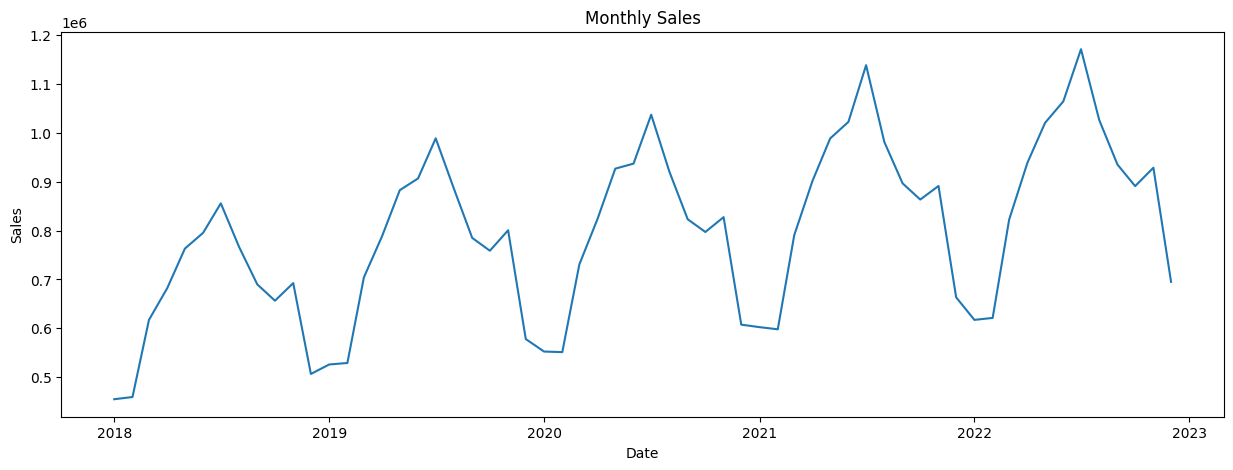

In [148]:
#visulaization

plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Sales")
plt.show()

In [149]:
#call the diff on sales column to make sales data stationary

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)
#1st feb emans 31 of jan

,date,sales,sales_diff
1,2018-02-01,459417,4513.0
2,2018-03-01,617382,157965.0
3,2018-04-01,682274,64892.0
4,2018-05-01,763242,80968.0
5,2018-06-01,795597,32355.0
6,2018-07-01,855922,60325.0
7,2018-08-01,766761,-89161.0
8,2018-09-01,689907,-76854.0
9,2018-10-01,656587,-33320.0
10,2018-11-01,692643,36056.0


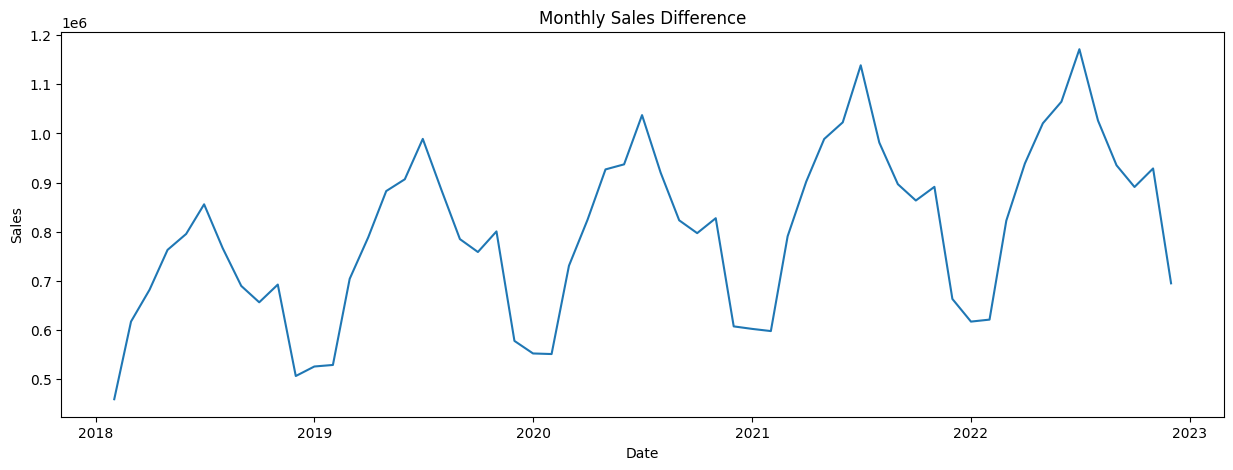

In [150]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Sales Difference")
plt.show()

In [151]:
#dropping of sales and date

supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [152]:
# Preparing the supervised data
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

# Drop rows with NaN values
supervised_data = supervised_data.dropna().reset_index(drop=True)
print(supervised_data.head(10))

   sales_diff   month_1   month_2   month_3   month_4   month_5   month_6  \
0      3130.0   19380.0 -186036.0   36056.0  -33320.0  -76854.0  -89161.0   
1    175184.0    3130.0   19380.0 -186036.0   36056.0  -33320.0  -76854.0   
2     84613.0  175184.0    3130.0   19380.0 -186036.0   36056.0  -33320.0   
3     93963.0   84613.0  175184.0    3130.0   19380.0 -186036.0   36056.0   
4     23965.0   93963.0   84613.0  175184.0    3130.0   19380.0 -186036.0   
5     82168.0   23965.0   93963.0   84613.0  175184.0    3130.0   19380.0   
6   -103414.0   82168.0   23965.0   93963.0   84613.0  175184.0    3130.0   
7   -100472.0 -103414.0   82168.0   23965.0   93963.0   84613.0  175184.0   
8    -26241.0 -100472.0 -103414.0   82168.0   23965.0   93963.0   84613.0   
9     41900.0  -26241.0 -100472.0 -103414.0   82168.0   23965.0   93963.0   

    month_7   month_8   month_9  month_10  month_11  month_12  
0   60325.0   32355.0   80968.0   64892.0  157965.0    4513.0  
1  -89161.0   60325.0   

In [153]:
#sales_diff for each region based on each month
#split the data into train and test

train_data = supervised_data[:-12]   #previous 12 months
test_data = supervised_data[-12:]    #coming 12 months
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [154]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [155]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


In [156]:
# Make prediction data frame to merge the predicted sales prices of all trained algorithms

sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [157]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [158]:
# To create a linear regression model and predicted output

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [159]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contains the input feature of the test data and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [160]:
result_list= []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+ act_sales[index])
lr_pre_series = pd.Series(result_list, name = "Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

In [161]:
#print(predict_df)

lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae )
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  17008.753834306415
Linear Regression MAE:  14076.177883552999
Linear Regression R2:  0.9900169434603457


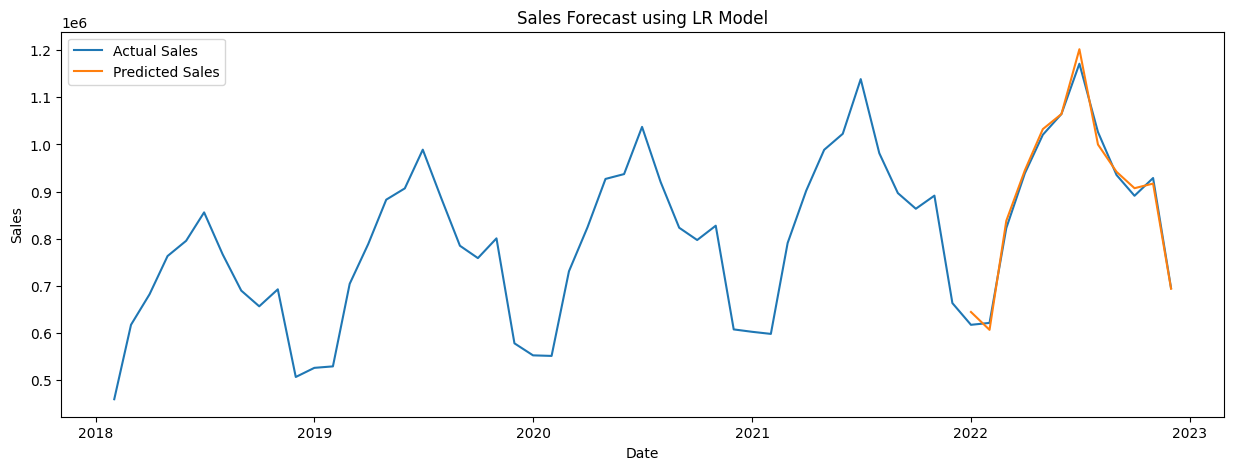

In [162]:
#Visualization of the prediction against eh actual sales

plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()
